In [71]:
import stan as ps
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from patsy import dmatrix 
import os
import arviz as az

# Importing nest_asyncio is only necessary to run pystan in Jupyter Notebooks.
import nest_asyncio
nest_asyncio.apply()

#Specify the number of chains to the number of availible cpu's.
n_chains = os.cpu_count()
n_samples = 1000
#Convert to int so Stan will not crash below.
n_warmup = int(n_samples/2)
#Specify step size.
stepS = .8

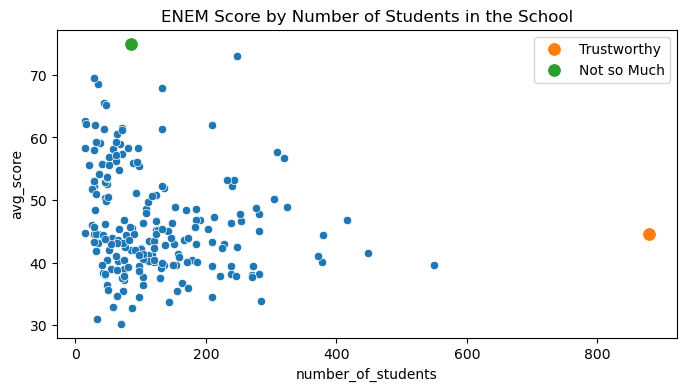

In [8]:
np.random.seed(876)
enem = pd.read_csv("https://raw.githubusercontent.com/matheusfacure/python-causality-handbook/master/causal-inference-for-the-brave-and-true/data/enem_scores.csv").sample(200)
plt.figure(figsize=(8,4))
sns.scatterplot(y="avg_score", x="number_of_students", data=enem)
sns.scatterplot(y="avg_score", x="number_of_students", s=100, label="Trustworthy",
                data=enem.query(f"number_of_students=={enem.number_of_students.max()}"))
sns.scatterplot(y="avg_score", x="number_of_students", s=100, label="Not so Much",
                data=enem.query(f"avg_score=={enem.avg_score.max()}"))
plt.title("ENEM Score by Number of Students in the School");

In [69]:
wage = pd.read_csv("https://raw.githubusercontent.com/matheusfacure/python-causality-handbook/master/causal-inference-for-the-brave-and-true/data/wage.csv")[["wage", "lhwage", "educ", "IQ"]]

wage.head(2)

,wage,lhwage,educ,IQ
0,769,2.956212,12,93
1,808,2.782539,18,119


In [10]:
group_wage = (wage
              .assign(count=1)
              .groupby("educ")
              .agg({"lhwage":"mean", "count":"count"})
              .reset_index())

group_wage

,educ,lhwage,count
0,9,2.856475,10
1,10,2.786911,35
2,11,2.855997,43
3,12,2.922168,393
4,13,3.021182,85
5,14,3.042352,77
6,15,3.090766,45
7,16,3.176184,150
8,17,3.246566,40
9,18,3.144257,57


In [40]:
lm = ''' data {
  int<lower=0> N;   // number of data items
  int<lower=0> K;   // number of predictors
  matrix[N, K] x;   // predictor matrix
  vector[N] y;      // outcome vector
}
parameters {
  vector[K] beta;       // coefficients for predictors
  real<lower=0> sigma;  // error scale
}
transformed parameters{
vector[N] mu;
 for (n in 1:N){
    mu[n] = x[n,] * beta;
    }
}

model {
  y ~ normal(mu,sigma);  // likelihood
}
'''

In [43]:
x = np.asarray(dmatrix('~1 + educ', data = wage))
y = wage['lhwage'].values

array([[ 1., 12.],
       [ 1., 18.],
       [ 1., 14.],
       ...,
       [ 1., 12.],
       [ 1., 12.],
       [ 1., 12.]])

In [74]:
np.asarray(dmatrix('~1 + C(educ)', data = wage))

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]])

In [70]:
d = {'N': len(y),
     'K': np.shape(x)[1],
     'y': y,
     'x': x   
}
sm = ps.build(lm, data = d)

Building: found in cache, done.
Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.


In [72]:
fit = sm.sample(num_chains = n_chains , num_samples = n_samples, num_warmup = n_warmup, stepsize = stepS)

Sampling:   0%
Sampling:  12% (1500/12000)
Sampling:  25% (3000/12000)
Sampling:  38% (4500/12000)
Sampling:  50% (6000/12000)
Sampling:  62% (7500/12000)
Sampling:  75% (9000/12000)
Sampling:  88% (10500/12000)
Sampling: 100% (12000/12000)
Sampling: 100% (12000/12000), done.
Messages received during sampling:
  Gradient evaluation took 7e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.07 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 5e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.05 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1.1e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.11 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 8e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.08 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1.4

In [73]:
az.summary(fit, var_names = ['beta', 'sigma'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[0],2.371,0.105,2.175,2.582,0.002,0.002,2069.0,2008.0,1.0
beta[1],0.048,0.008,0.033,0.062,0.000,0.000,2090.0,2199.0,1.0
sigma,0.065,0.020,0.035,0.101,0.000,0.000,2194.0,2125.0,1.0


In [63]:
lmweights = ''' data {
  int<lower=0> N;   // number of data items
  int<lower=0> K;   // number of predictors
  matrix[N, K] x; // predictor matrix
  vector[N] weights;
  vector[N] y;      // outcome vector
}
parameters {
  vector[K] beta;       // coefficients for predictors
  real<lower=0> sigma;  // error scale
}
transformed parameters{
vector[N] mu;
 for (n in 1:N){
    mu[n] = x[n,] * beta;
    }
}

model {
for (i in 1:N){
  target += weights[i] * normal_lpdf(y[i] | mu[i], sigma);
    }
}
'''

In [64]:
x = np.asarray(dmatrix('~1 + educ', data = group_wage))
y = group_wage['lhwage'].values
weights= group_wage['count'].values

In [66]:
d = {'N': len(y),
     'K': np.shape(x)[1],
     'weights': weights,
     'y': y,
     'x': x   
}
sm_W = ps.build(lmweights, data = d)

Building: found in cache, done.
Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.


In [67]:
fit_W = sm.sample(num_chains = n_chains , num_samples = n_samples, num_warmup = n_warmup, stepsize = stepS)

Sampling:   0%
Sampling:  12% (750/6000)
Sampling:  25% (1500/6000)
Sampling:  38% (2250/6000)
Sampling:  50% (3000/6000)
Sampling:  62% (3750/6000)
Sampling:  75% (4500/6000)
Sampling:  88% (5250/6000)
Sampling: 100% (6000/6000)
Sampling: 100% (6000/6000), done.
Messages received during sampling:
  Gradient evaluation took 7e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.07 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 8e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.08 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 9e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.09 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 5e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.05 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 9e-06 seconds
  10

In [68]:
az.summary(fit, var_names = ['beta', 'sigma'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[0],2.298,0.093,2.129,2.468,0.003,0.002,1250.0,1447.0,1.01
beta[1],0.053,0.007,0.041,0.066,0.000,0.000,1258.0,1447.0,1.01
sigma,0.439,0.010,0.421,0.457,0.000,0.000,1769.0,2036.0,1.00
